# Toxicity Classification:

####  Data: <br>

- Source: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data
- We have one single csv file for training and one cvs file to test.
- Columns in train data:
    - Comment_text: This is the data in string format which we have to use to find the toxicity.
    - target: Target values which are to be predicted (has values between 0 and 1)
    - Data also has additional toxicity subtype attributes: (Model does not have to predict these)
        - severe_toxicity
        - obscene
        - threat
        - insult
        - identity_attack
        - sexual_explicit
    - Comment_text data also has identity attributes carved out from it, some of which are:
        - male
        - female
        - homosexual_gay_or_lesbian
        - christian
        - jewish
        - muslim
        - black
        - white
        - asian
        - latino
        - psychiatric_or_mental_illness
    - Apart from above features the train data also provides meta-data from jigsaw like:
        - toxicity_annotator_count
        - identity_anotator_count
        - article_id
        - funny
        - sad
        - wow
        - likes
        - disagree
        - publication_id
        - parent_id
        - article_id
        - created_date
        

####  Example Datapoints and Labels:<br>

**Comment:** i'm a white woman in my late 60's and believe me, they are not too crazy about me either!!<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 1.0, white: 1.0 (all others 0.0)

**Comment:** Why would you assume that the nurses in this story were women?<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 0.8 (all others 0.0)

**Comment:** Continue to stand strong LGBT community. Yes, indeed, you'll overcome and you have.<br><r>

- Toxicity Labels: All 0.0
- Identity Mention Labels: homosexual_gay_or_lesbian: 0.8, bisexual: 0.6, transgender: 0.3 (all others 0.0)



We have to predict the toxicity level(target attribute). The values range from 0 to 1 inclusive. This is a regression problem. It can also be treated as a classification problem if we take every value below 0.5 to be non-toxic and above it to be toxic, we would then get a binary classification problem.

The competition will use ROC_AUC as the metric after converting the numeric target variable into a categorical variable by using a threshold of 0.5. Any comment above 0.5 will be assumed to be toxic and below it non-toxic. For our training and evaluation we will use the MSE(Mean Squared Error).<br>

**Objectives:** Predict the toxicity of a comment made by the user. (0 -> not toxic, 1 -> highest toxicity level)

## Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import re

from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer

import math
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error, accuracy_score, classification_report
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

import gensim
import string
import tensorflow as tf

import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
import warnings
from keras import backend as K


# Import Tensorflow utility device_lib to get more information about the GPU
# This will help verify if TF is using the intended GPU
from tensorflow.python.client import device_lib

# Helper function to get information about all available GPUs in a list
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x for x in local_device_protos if x.device_type == 'GPU']
    
# Get information of all available GPUs
gpu_info = get_available_gpus()

# Display GPU information
for i, gpu in enumerate(gpu_info):
    print(f"################## GPU: {i} ##########################")
    print(f"Device Type: {gpu.device_type}")
    print(f"GPU ID: {gpu.name}")
    print(f"Physical Device Description:\n\t{gpu.physical_device_desc}")
    print("####################################################")


################## GPU: 0 ##########################
Device Type: GPU
GPU ID: /device:GPU:0
Physical Device Description:
	device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
####################################################


## Reading Data:

In [2]:
train_df = pd.read_csv(r"C:\Users\SOUMYA\@AI\NLP\train_toxicity.csv", index_col='id', engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [15]:
test_df = pd.read_csv(r"C:\Users\SOUMYA\@AI\NLP\test_toxicity.csv", index_col='id', engine='python')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [4]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


**Looking at count values of asian,atheist etc columns we see that there are a lot of Null values present, but this is OK as we are only supposed to use 'comment_text' column so dealing with these is not really necessary here.**

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                       

In [6]:
train_df.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

**No Null values for target and comment_text columns**

In [7]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (1804874, 44) (97320, 1)


## Exploratory Data Analysis:

### 1. Target Feature:

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


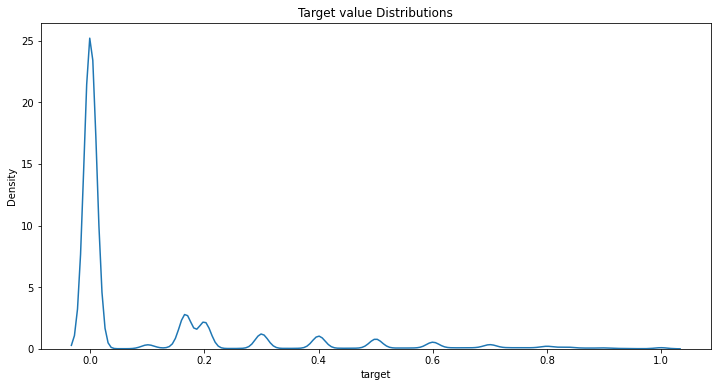

In [9]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

**We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


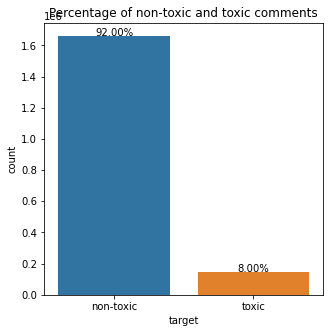

In [10]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")

# Plot the number and percentage of toxic and non-toxic comments.
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

# Plot the count plot.
cntplot = sns.countplot(temp)
cntplot.set_title('Percentage of non-toxic and toxic comments')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**The dataset is imbalanced as 92% of the comments are non-toxic and only 8% are toxic**

### 2. Toxicity Subtype Features:
- severe_toxicity
- obscene
- threat
- insult
- identity_attack

In [11]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit according to my needs
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

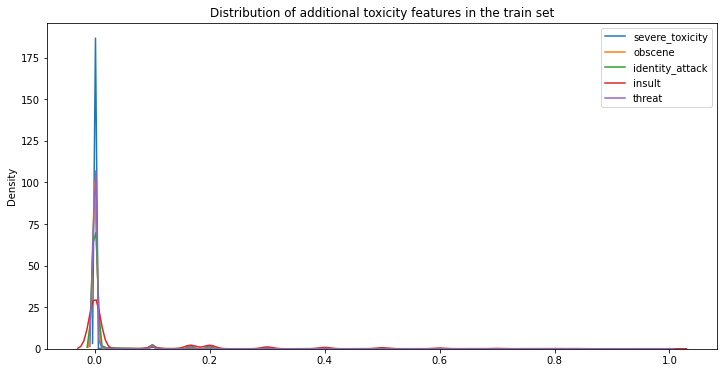

In [12]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

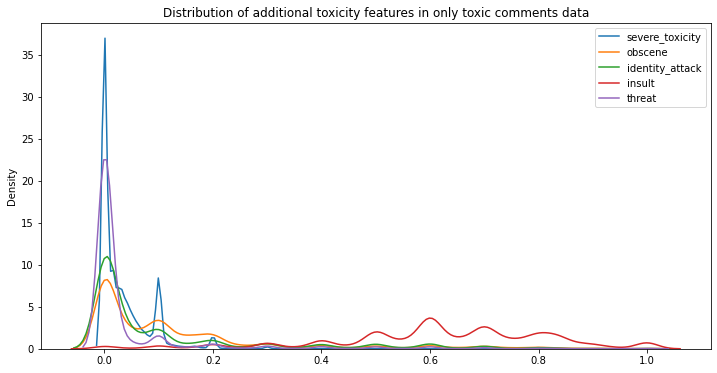

In [13]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

**We see that for toxic comments data, there are more insulting comments as compared to obscene comments**

In [14]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


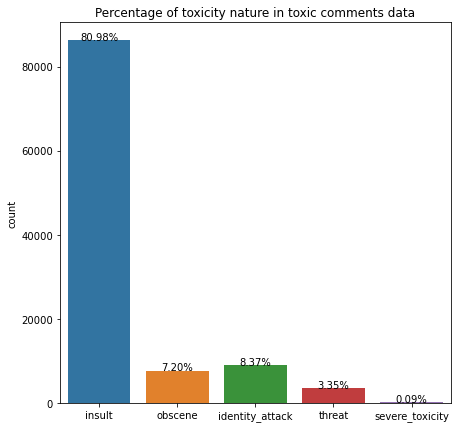

In [15]:
x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment
fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**In our train dataset only 8% of the data was toxic. Out of that 8%, 81% of the toxic comments made are insults, 8.37% are identity attacks, 7.20% are obscene, 3.35% are threats and a very small amount of toxic comments are severly toxic.**

### 3. Identity Attributes:

Sensitive topics:

- male
- female
- homosexual_gay_or_lesbian
- bisexual
- heterosexual
- christian
- jewish
- muslim
- black
- white
- asian
- latino

In [16]:
temp = train_df.dropna(axis = 0, how = 'any')

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

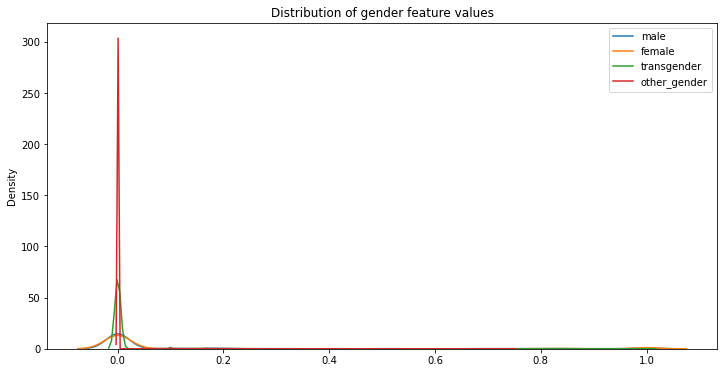

In [17]:
features = ['male', 'female', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender feature values", temp)

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

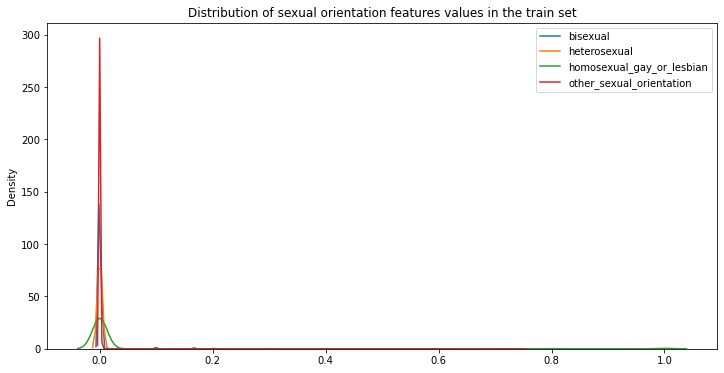

In [18]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set", temp)

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

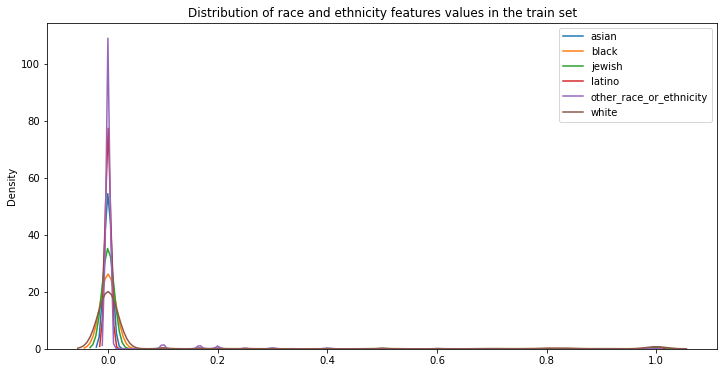

In [19]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


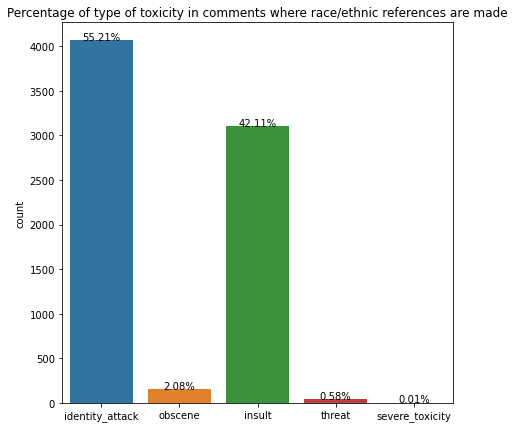

In [20]:
# Get data where race/ethnic references are made.
cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where race/ethnic references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**We see that the toxic comments involving words like black, asian etc. are mainly used for identity attacks or insults.**

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


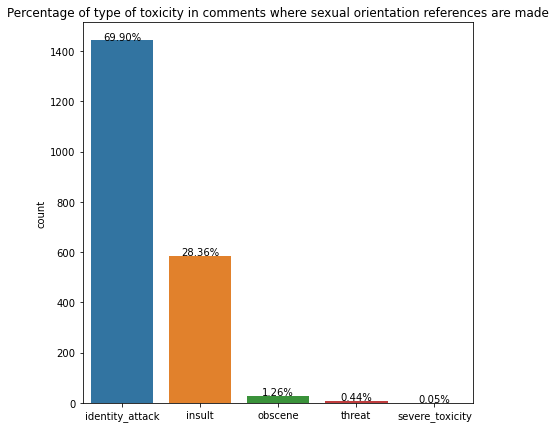

In [21]:
# Get data where race/ethnic references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where sexual orientation references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**We see from the plot that the toxic comments where sexual orientation references are made are mostly used for identity attacks.** 

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


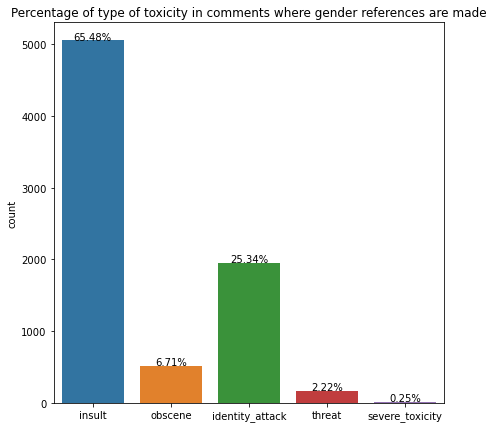

In [22]:
# Get data where race/ethnic references are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where gender references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**From the plot we see that the toxic comments which involve words like male, female etc are insults.**

### 4. Features generated by users feedback:

- funny
- sad
- wow
- likes
- disagree

In [23]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit
def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()   

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


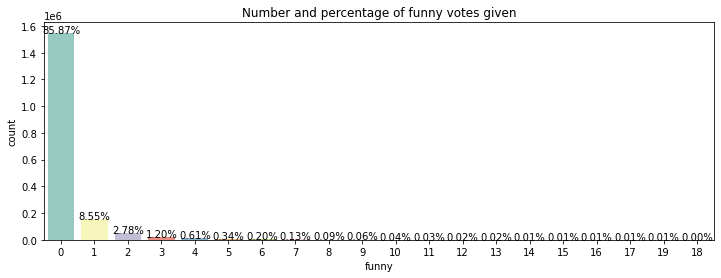

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


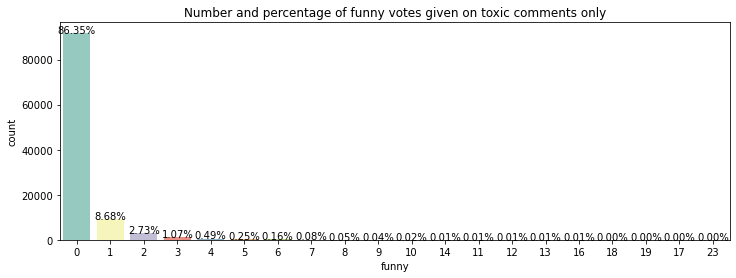

In [24]:
plot_count('funny','funny votes given', train_df, 3)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


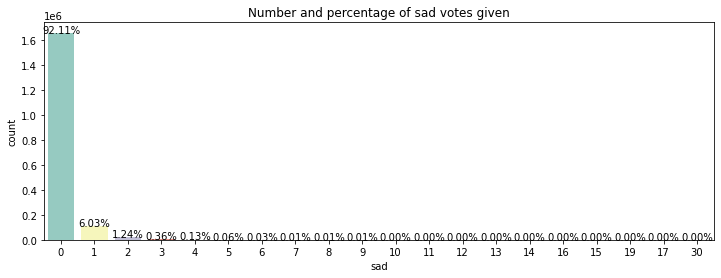

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


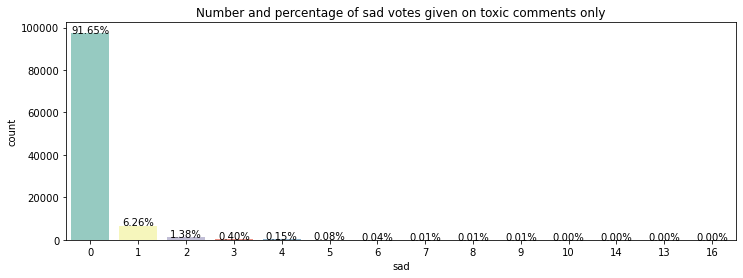

In [25]:
plot_count('sad','sad votes given', train_df, 3)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


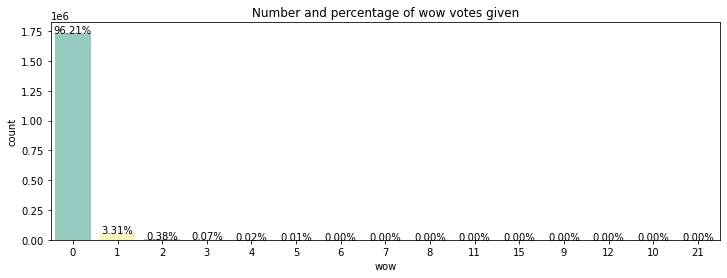

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


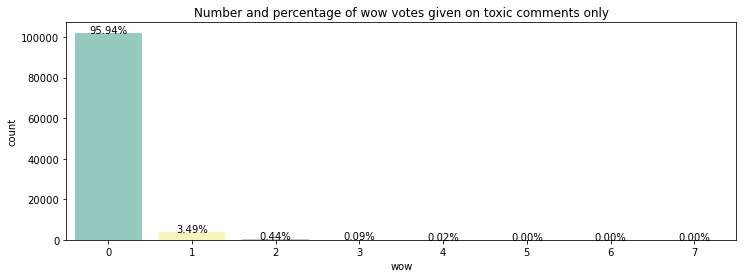

In [26]:
plot_count('wow','wow votes given', train_df, 3)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


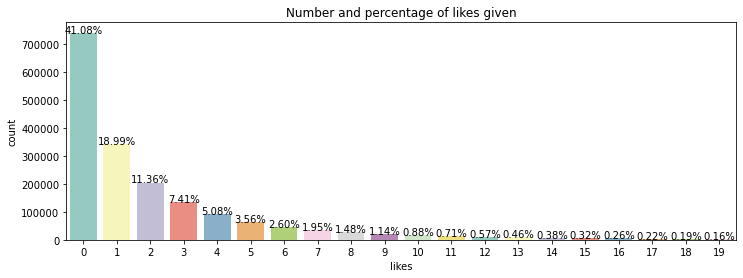

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


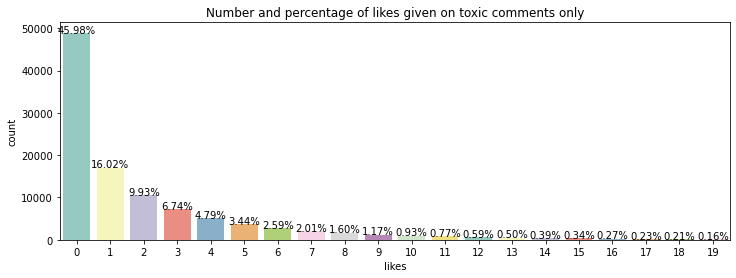

In [27]:
plot_count('likes','likes given', train_df, 3)
plot_count('likes', 'likes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


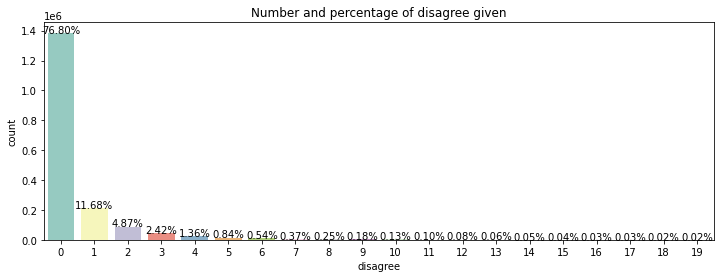

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


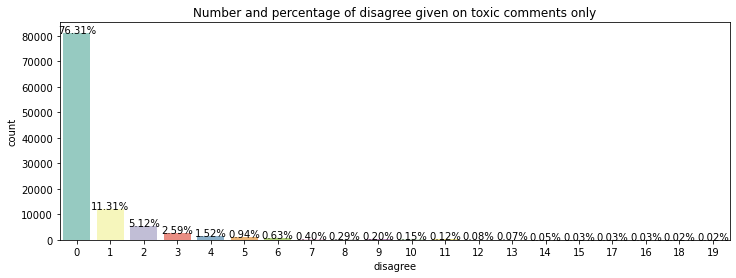

In [28]:
plot_count('disagree','disagree given', train_df, 3)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

### 5. Comments_text Feature:

In [29]:
# Code From: https://www.kaggle.com/gpreda/jigsaw-eda
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

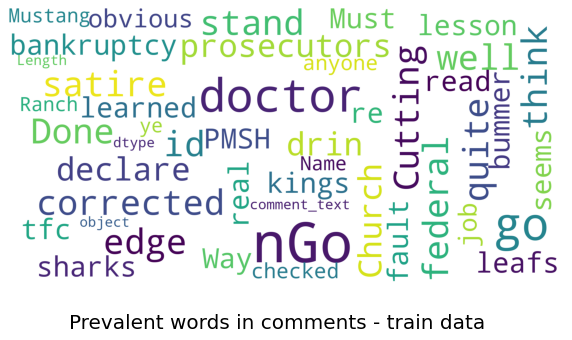

In [30]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

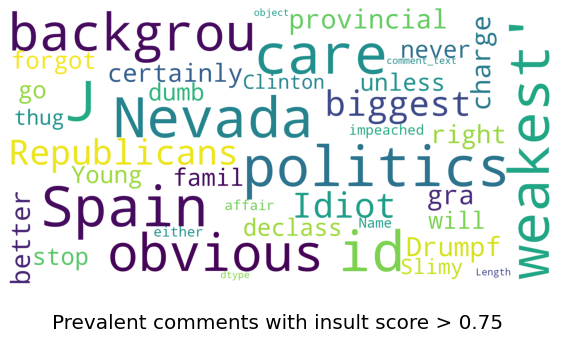

In [31]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

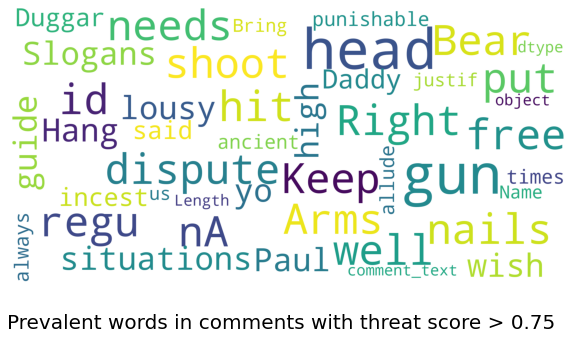

In [32]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

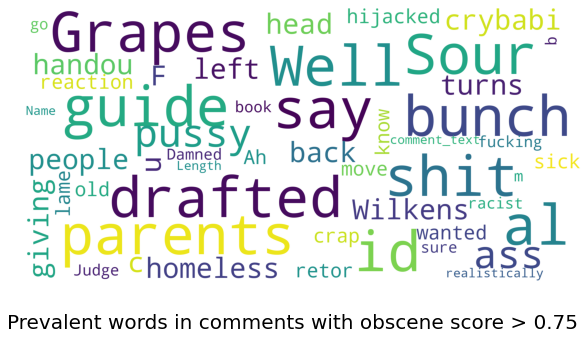

In [33]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

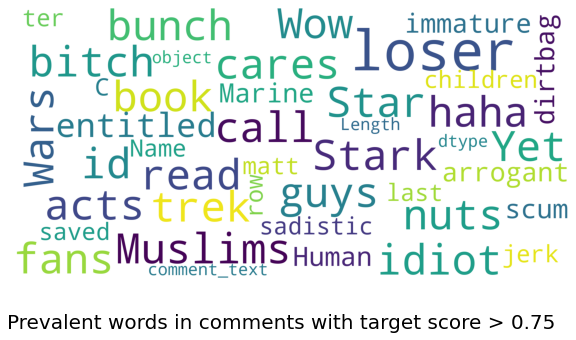

In [34]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

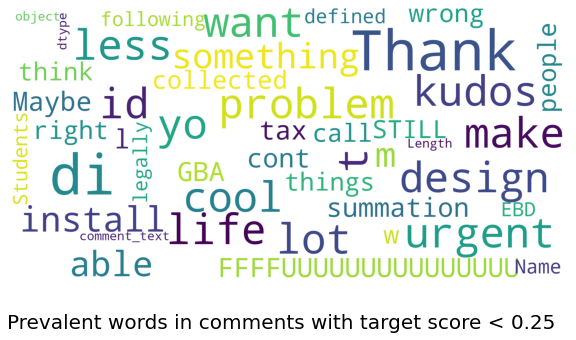

In [35]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

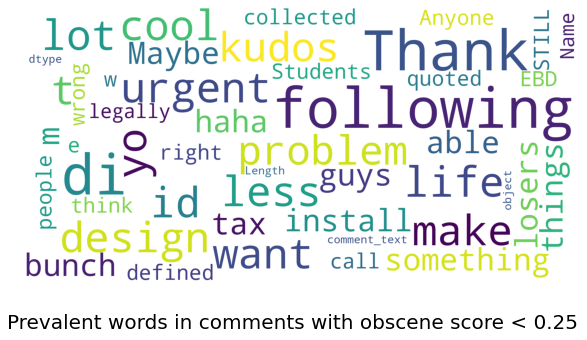

In [36]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

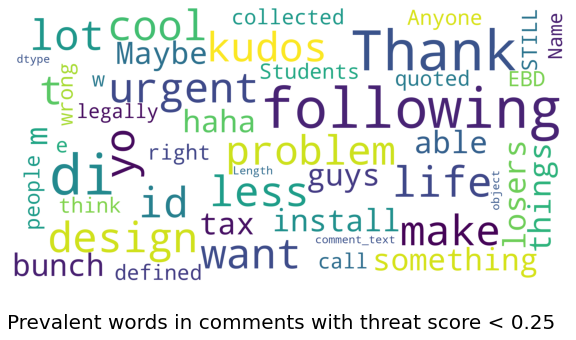

In [37]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

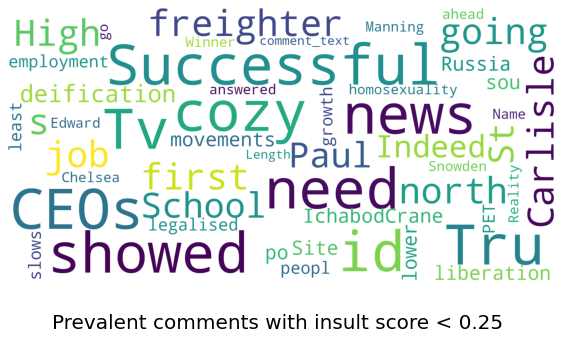

In [38]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

## Preprocessing Text and Train-Test Split:

In [16]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [40]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

Wall time: 12min 59s


In [41]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha guy bunch loser


In [17]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

Wall time: 41.9 s


In [43]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
print(feature, output)

                                         preprocessed_text
id                                                        
59848    cool like would want mother read realli great ...
59849    thank would make life lot less anxieti induc k...
59852              urgent design problem kudo take impress
59855                        someth abl instal site releas
59856                                 haha guy bunch loser
...                                                    ...
6333967  mayb tax thing would collect product import re...
6333969         call peopl still think divin role creation
6333982                     thank right wrong follow advic
6334009  anyon quot follow exchang even apocryph would ...
6334010  student defin ebd legal disabl elig special se...

[1804874 rows x 1 columns]            target
id               
59848    0.000000
59849    0.000000
59852    0.000000
59855    0.000000
59856    0.893617
...           ...
6333967  0.000000
6333969  0.000000
6333982  0.000000
6334009

In [44]:
feature.to_pickle('feature.pkl')
output.to_pickle('output.pkl')

In [18]:
test_df.to_pickle('test_df.pkl')

## Loading data:

In [26]:
feature = pd.read_pickle('feature.pkl')
output = pd.read_pickle('output.pkl')

In [19]:
test_df = pd.read_pickle('test_df.pkl')

In [3]:
print(feature, output)

                                         preprocessed_text
id                                                        
59848    cool like would want mother read realli great ...
59849    thank would make life lot less anxieti induc k...
59852              urgent design problem kudo take impress
59855                        someth abl instal site releas
59856                                 haha guy bunch loser
...                                                    ...
6333967  mayb tax thing would collect product import re...
6333969         call peopl still think divin role creation
6333982                     thank right wrong follow advic
6334009  anyon quot follow exchang even apocryph would ...
6334010  student defin ebd legal disabl elig special se...

[1804874 rows x 1 columns]            target
id               
59848    0.000000
59849    0.000000
59852    0.000000
59855    0.000000
59856    0.893617
...           ...
6333967  0.000000
6333969  0.000000
6333982  0.000000
6334009

In [58]:
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(1353655, 1)
(451219, 1)
(1353655, 1)
(451219, 1)


In [5]:
X_train.head()

,preprocessed_text
id,
5079971,bingo
5988940,whole discuss scheer stupid
251361,yeah high qualiti school high socio econom sta...
5480148,brilliant wish could give 10 vote
964596,defend canadian interest defend interest get b...


In [6]:
X_cv.head()

,preprocessed_text
id,
969446,58 canadian agre 20 canadian pay 80 incom tax ...
5805852,base comment sure drive new dodg unruli crowd ...
279872,start work home googl far best job last wednes...
5647743,like bever hill billi trumpo idiot greasi son ...
636104,agre actual matter power give go ahead someth ...


In [21]:
X_test_df = test_df[['preprocessed_text']]
X_test_df.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


## Training Models:

### 1. Bag of Words (BoW):

In [28]:
%%time
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)
Wall time: 2min 49s


#### 1.1 SGDRegressor:

##### 1.1.1 Hyperparameter Tuning:

In [29]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  1.0379838776795247
Mean Squared Error on cv set:  0.14016294170421137
**************************************************
1e-05 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  1.8382206740834728
Mean Squared Error on cv set:  0.14972647589448226
**************************************************
0.0001 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.024490997623167976
Mean Squared Error on cv set:  0.024437461842210684
**************************************************
0.0001 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.6682647725239701
Mean Squared Error on cv set:  0.06148580739147781
**************************************************
0.001 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03145864519353554
Mean Squared Error on cv set:  0.031361706352506256
**************************************************
0.001 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.06862759443401197
Mean Squared Error on cv set:  0.02607566354866229
**************************************************
0.01 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03885779830122996
Mean Squared Error on cv set:  0.038781931485473556
**************************************************
0.01 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.02795123195608114
Mean Squared Error on cv set:  0.02796485302406813
**************************************************
0.1 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03885779008240573
Mean Squared Error on cv set:  0.03878200640832795
**************************************************
0.1 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03487135164107322
Mean Squared Error on cv set:  0.03482960344234563
**************************************************
1 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03885778538343646
Mean Squared Error on cv set:  0.03878198156381178
**************************************************
1 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03802668886047629
Mean Squared Error on cv set:  0.037957324338116154
**************************************************
10 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03885778484919938
Mean Squared Error on cv set:  0.038781962357512044
**************************************************
10 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03877403699956623
Mean Squared Error on cv set:  0.03869874741767427
**************************************************
100 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03885778464717118
Mean Squared Error on cv set:  0.0387819664254646
**************************************************
100 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.0388538287314911
Mean Squared Error on cv set:  0.03877812707163631
**************************************************


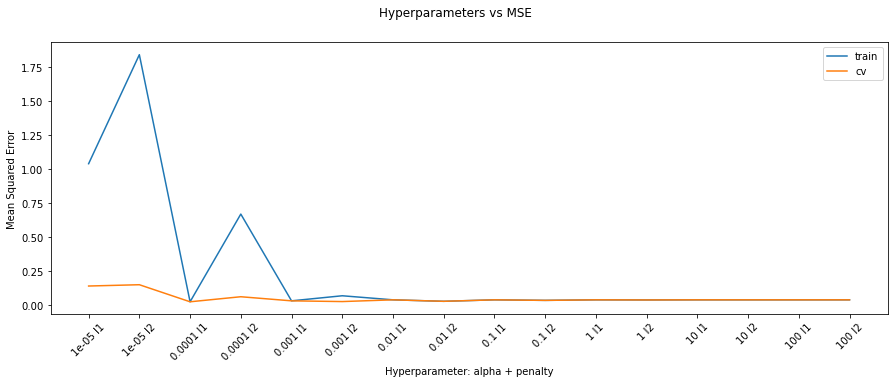

In [30]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [31]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=64,epochs=epochs,verbose=1)

##### 1.1.2 Feature Importance:

In [32]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.425591
stupid,0.345673
moron,0.312025
pathet,0.289665
crap,0.279330
dumb,0.257961
hypocrit,0.257096
ass,0.235261
clown,0.229730
damn,0.215875


In [33]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.014254
white hous,-0.013718
agre,-0.012139
http,-0.010402
https,-0.010300
great,-0.009345
good,-0.009298
may,-0.008790
com,-0.008742
reason,-0.008649


#### 1.2 Decision Trees:

##### 1.2.1 Hyperparameter Tuning:

In [54]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03307068376113142
Mean Squared Error on cv set:  0.03322772930054923
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.033070683761131425
Mean Squared Error on cv set:  0.03322772930054923
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.033072689879985684
Mean Squared Error on cv set:  0.03322886772927767
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.031983614336493035
Mean Squared Error on cv set:  0.03215642754355275
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03198713386115143
Mean Squared Error on cv set:  0.032155793886119
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train

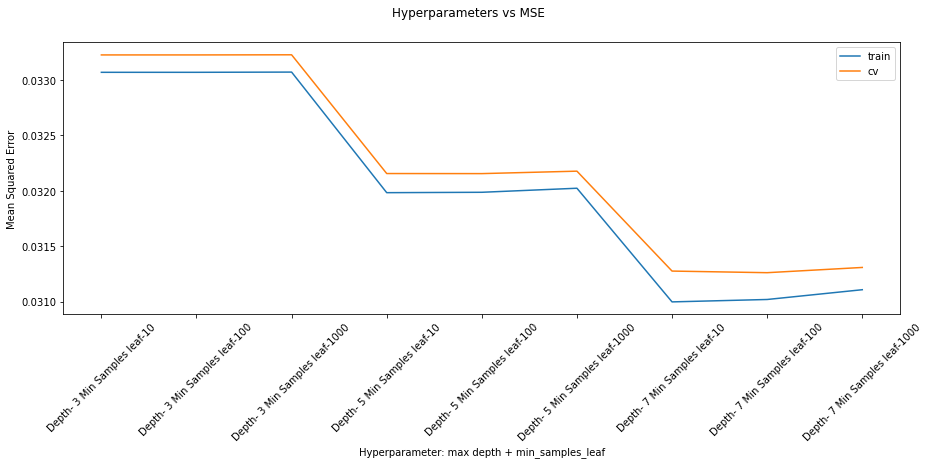

In [55]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [56]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

##### 1.2.2 Feature Importance:

In [57]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.399040
idiot,0.263043
fool,0.069732
pathet,0.068388
moron,0.062879
racist,0.060555
dumb,0.055115
one,0.003925
would,0.003641
year,0.002499


### 2. Term Frequency - Inverse Document Frequency (TFIDF) :

In [4]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


#### 2.1 SGDRegressor:

##### 2.1.1 Hyperparameter Tuning:

In [6]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        print(model)
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=1e-05, penalty='l1')
Mean Squared Error on train set:  0.025237361008476226
Mean Squared Error on cv set:  0.02537112521638951
**************************************************
1e-05 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=1e-05)
Mean Squared Error on train set:  0.02387834606640904
Mean Squared Error on cv set:  0.024053954553727032
**************************************************
0.0001 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(penalty='l1')
Mean Squared Error on train set:  0.029695275870836094
Mean Squared Error on cv set:  0.029815294511359152
**************************************************
0.0001 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor()
Mean Squared Error on train set:  0.024990519394943556
Mean Squared Error on cv set:  0.02515908101397798
**************************************************
0.001 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.001, penalty='l1')
Mean Squared Error on train set:  0.038260075959281076
Mean Squared Error on cv set:  0.03836911769409116
**************************************************
0.001 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.001)
Mean Squared Error on train set:  0.030031636668071852
Mean Squared Error on cv set:  0.03017114133944782
**************************************************
0.01 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.01, penalty='l1')
Mean Squared Error on train set:  0.038815134987703864
Mean Squared Error on cv set:  0.03890991463551476
**************************************************
0.01 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.01)
Mean Squared Error on train set:  0.03711742638529686
Mean Squared Error on cv set:  0.037219003907525416
**************************************************
0.1 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.1, penalty='l1')
Mean Squared Error on train set:  0.038815144491931235
Mean Squared Error on cv set:  0.038909937906123036
**************************************************
0.1 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.1)
Mean Squared Error on train set:  0.03862303969877694
Mean Squared Error on cv set:  0.038718524288257054
**************************************************
1 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=1, penalty='l1')
Mean Squared Error on train set:  0.03881513458745276
Mean Squared Error on cv set:  0.03890991239602973
**************************************************
1 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=1)
Mean Squared Error on train set:  0.038795702187084356
Mean Squared Error on cv set:  0.03889051329524711
**************************************************
10 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=10, penalty='l1')
Mean Squared Error on train set:  0.038815134484015815
Mean Squared Error on cv set:  0.03890991155069712
**************************************************
10 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=10)
Mean Squared Error on train set:  0.0388128342969462
Mean Squared Error on cv set:  0.03890762979596583
**************************************************
100 l1 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=100, penalty='l1')
Mean Squared Error on train set:  0.03881513665957609
Mean Squared Error on cv set:  0.038909903104920734
**************************************************
100 l2 :


C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=100)
Mean Squared Error on train set:  0.038814959622736116
Mean Squared Error on cv set:  0.03890974782186506
**************************************************


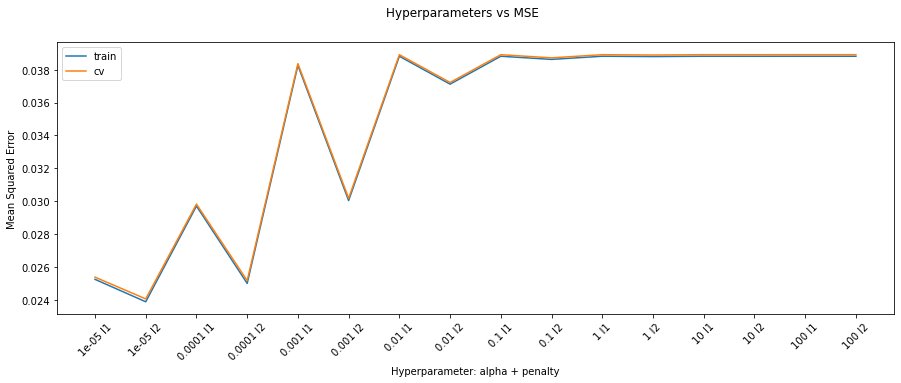

In [60]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.1.2 Feature Importance:

In [61]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

C:\Users\SOUMYA\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,weights
stupid,1.572007
idiot,1.264156
fool,0.669184
ignor,0.601291
dumb,0.600573
pathet,0.591578
ridicul,0.573226
moron,0.572610
loser,0.550936
liar,0.518100


In [62]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.094279
interest,-0.085706
agre,-0.079334
stori,-0.076773
great,-0.072570
new,-0.069363
may,-0.068748
good,-0.068564
year,-0.067293
chang,-0.066808


#### 2.2 Decision Trees:

##### 2.2.1 Hyperparameter Tuning:

In [63]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.0328588059703051
Mean Squared Error on cv set:  0.033037096032842
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.0328588059703051
Mean Squared Error on cv set:  0.033037096032842
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.0328588059703051
Mean Squared Error on cv set:  0.033037096032842
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03171453637791185
Mean Squared Error on cv set:  0.03189525002722749
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.031715529158433294
Mean Squared Error on cv set:  0.031898122680002534
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train set:  0

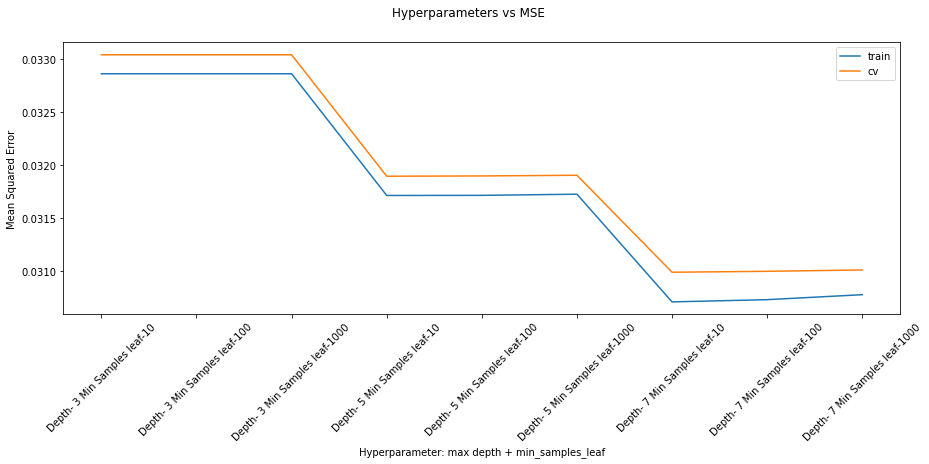

In [64]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.2.2 Feature Importance:

In [65]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.407030
idiot,0.266198
fool,0.073639
pathet,0.069976
moron,0.063969
racist,0.058327
dumb,0.054002
white,0.002087
ignor,0.001004
fool peopl,0.000922


### 3. Features for LSTM:

In [9]:
class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [10]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [11]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

C:\Users\SOUMYA\AppData\Local\Temp/ipykernel_13244/3506068974.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)


In [12]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

(1353655, 350)
(451219, 350)
(97320, 350)


In [13]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [14]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(CuDNNLSTM(128, return_sequences=True))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 350, 100)          20210700  
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 350, 128)          117760    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 20,460,685
Trainable params: 20,460,685
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(lstm_train, y_train, epochs=5,
                    batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

Epoch 1/5


In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

## Conclusions:



1. **BagOfWords:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
        - Train MSE Loss: 0.02281
        - CV MSE Loss: 0.02326
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.0310
        - CV MSE Loss: 0.03128
2. **TFIDF:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
        - Train MSE Loss: 0.02556
        - CV MSE Loss: 0.02584
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.03073
        - CV MSE Loss: 0.03122
3. **LSTM:**
    - Train MSE Loss: 0.0157
    - CV MSE Loss: 0.0162